<h4>Importing Modules</h4>

In [1]:
#Numpy for Numerical Analysis
#Pandas for DataFrames and Series
#Matplotlib for Data Visualisation
#Yfinance for Dataset Download

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as si

<h5>Considering Amazon.com Inc. Stock Data from the S&amp;P 500 Index<h5>

In [2]:
#Downloading Stock Data from Yahoo Finance with yfinance
DATA = yf.download("AMZN", start="2020-01-01", end="2020-10-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
#Summary Statistics
#Describing data with pandas
DATA.describe()

,Open,High,Low,Close,Adj Close,Volume
count,212.000000,212.000000,212.000000,212.000000,212.000000,2.120000e+02
mean,2579.203259,2616.308677,2540.667452,2579.799619,2579.799619,5.102789e+06
std,553.313446,558.589270,539.393288,547.584980,547.584980,2.031808e+06
min,1641.510010,1759.449951,1626.030029,1676.609985,1676.609985,2.088000e+06
25%,2020.027496,2042.825012,1999.592499,2009.147522,2009.147522,3.583175e+06
50%,2472.719971,2494.329956,2447.660034,2476.199951,2476.199951,4.721250e+06
75%,3144.460022,3184.809998,3101.262451,3138.425049,3138.425049,6.100125e+06
max,3547.000000,3552.250000,3486.689941,3531.449951,3531.449951,1.556730e+07


In [4]:
#Inspecting First Five Rows in Dataset
DATA.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,1842.0,1853.260010,1832.229980,1847.839966,1847.839966,2506500
2020-01-02,1875.0,1898.010010,1864.150024,1898.010010,1898.010010,4029000
2020-01-03,1864.5,1886.199951,1864.500000,1874.969971,1874.969971,3764400
2020-01-06,1860.0,1903.689941,1860.000000,1902.880005,1902.880005,4061800
2020-01-07,1904.5,1913.890015,1892.040039,1906.859985,1906.859985,4044900


In [5]:
#Calculating For Historical Volatility of Amazon.com Inc..
#Considering 190 Trading Days between January and October 2020

DATA['Log Return'] = np.log(DATA['Adj Close'] / DATA['Adj Close'].shift(1)) 
hist_vol = np.sqrt(190) * DATA['Log Return'].std()
print('The Volatilty after 190 Trading Days is', round(hist_vol*100,2), '%')

The Volatilty after 190 Trading Days is 34.78 %


array([<AxesSubplot:xlabel='Date'>], dtype=object)

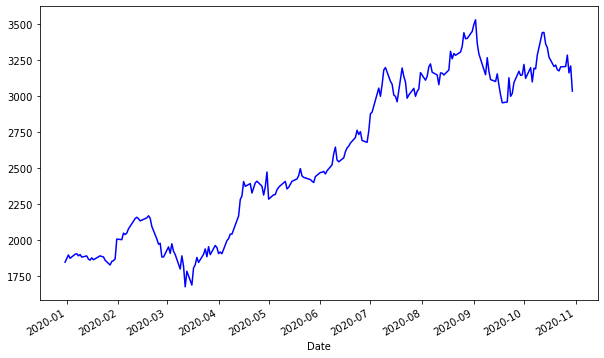

In [6]:
#Plot of Stock Movement with Matplotlib
DATA['Adj Close'].plot(subplots=True, color='blue', figsize=(10, 6))

<h3>Derivative and Pricing Value</h3>
<h5>Using Black Scholes Model and Binomial Tree</h5>

In [8]:
#Black Schole Model
def Black_Scholes(S, K, T, r, q, vol, option):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if option == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif option == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [16]:
S = np.linspace(50,150,11)
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Call [i] = Black_Scholes(S[i], 100, 10.0/12.0, 0.06, 0.03, 0.34, 'call')
    Put [i] = Black_Scholes(S[i], 100, 10.0/12.0, 0.06, 0.03, 0.34, 'put')

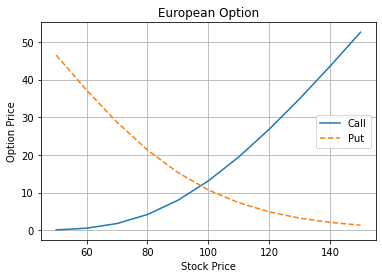

In [17]:
fig = plt.figure()
plt.plot(S, Call, '-')
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Call','Put'])

In [11]:
def Binomial(n, S, K, r, v, t, option):  
    At = t/n 
    u = np.exp(v*np.sqrt(At))
    d = 1./u
    p = (np.exp(r*At)-d) / (u-d) 

    #Binomial price tree
    stockvalue = np.zeros((n+1,n+1))
    stockvalue[0,0] = S
    for i in range(1,n+1):
        stockvalue[i,0] = stockvalue[i-1,0]*u
        for j in range(1,i+1):
            stockvalue[i,j] = stockvalue[i-1,j-1]*d
    
    #option value at final node   
    optionvalue = np.zeros((n+1,n+1))
    for j in range(n+1):
        if option=="call": # Call
            optionvalue[n,j] = max(0, stockvalue[n,j]-K)
        elif option=="put": #Put
            optionvalue[n,j] = max(0, K-stockvalue[n,j])
    
    #backward calculation for option price    
    for i in range(n-1,-1,-1):
        for j in range(i+1):
                if option=="put":
                    optionvalue[i,j] = max(0, K-stockvalue[i,j], np.exp(-r*At)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1]))
                elif option=="call":
                    optionvalue[i,j] = max(0, stockvalue[i,j]-K, np.exp(-r*At)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1]))
    return optionvalue[0,0]

In [18]:
n = 3
S = np.linspace(50,150,11)
r = 0.06
K = 1
v = 0.34
t = 10.0 / 12.0

In [19]:
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Call [i] = Binomial(n, S[i], K, r, v, t, option="call")
    Put [i] = Binomial(n, S[i], K, r, v, t, option="call")

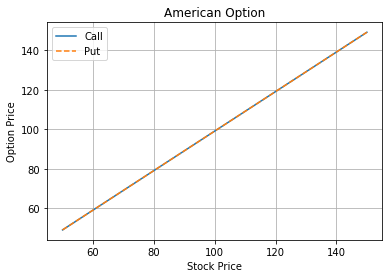

In [20]:
fig = plt.figure()
plt.plot(S, Call, '-')
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('American Option')
plt.legend(['Call','Put'])

<h4>Calculating Greeks</h4>

In [15]:
#DELTA
def delta(S, K, T, r, q, vol, option):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if option == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif option == "put":
        delta = - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    return delta

In [ ]:
delta(100, 100, 10.0/12.0, 0.06, 0.03, 0.34, 'call')

In [21]:
delta(100, 100, 10.0/12.0, 0.05, 0.03, 0.34, 'put')

-0.4069660854302571

In [23]:
#GAMMA

def gamma(S, K, T, r, q, vol): 
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * T)
    
    return gamma

In [24]:
gamma(100, 100, 1, 0.05, 0.03, 0.25)

0.014863795455492166

In [25]:
#RHO

def rho(S, K, T, r, q, vol, option):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if option == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif option == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [26]:
rho(100, 100, 10.0/12.0, 0.06, 0.03, 0.34, 'call')

37.276328904381955

In [27]:
rho(100, 100, 10.0/12.0, 0.06, 0.03, 0.34, 'put')

-41.99278980401088

In [29]:
#VEGA

def vega(S, K, T, r, q, vol):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [30]:
vega(100, 100, 10.0/12.0, 0.06, 0.03, 0.34)

34.54577523796066

In [31]:
#THETA

def theta(S, K, T, r, q, vol, option):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if option == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif option == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [32]:
theta(100, 100, 10.0/12.0, 0.06, 0.03, 0.34, 'call')

7.995627795478418

In [34]:
theta(100, 100, 10.0/12.0, 0.06, 0.03, 0.34, 'put')

8.880495312528815